Inf-Gram final project.
Objectives:

Import and process an unknown dataset
Do some descriptive analysis of the data
Compute different classification model
Evaluate the models and select the final model
Context: For this project, we will be working on biomedical data related to vertebral column conditions. In particular, disk-hernia and spondylolisthesis. The first one, disk-hernia, is a condition in which the annulus fibrosus (outer portion) of the vertebral disc is torn, enabling the nucleus (inner portion) to herniate or extrude through the fibers. The herniated material can compress the nerves around the disc and create pain that can radiate through the back and sometimes down the arms (if the herniation is in the cervical spine) and legs (if the herniation is in the lumbar spine). The second condition, spondylolisthesis is a slipping of vertebra that occurs, in most cases, at the base of the spine. The extent of slippage determines the grade of sponylolisthesis. The two conditions can be diagnosed visually via physical exam, X-ray, MRI and radiology technologies.

Data: The dataset column_3C has 310 instances of patients data. Each patient is represented in the dataset by six bio-mechanical attributes derived from the shape and orientation of the pelvis and lumbar spine:

pelvic incidence: pelvic tilt + sacral slope
pelvic tilt: is the angle between a vertical line and the CS segment. Denotes spatial orientation of pelvis.
lumbar lordosis angle
sacral slope The sacral slope is the angle of the sacral plateau to the horizontal. The degree of the sacral slope determines the position of the lumbar spine, since the sacral plateau forms the bae of the spine
pelvic radius
degree_spondylolisthesis: degree of severity of spondylolisthesis. Grade 1 being least severe through to grade 4 most severe.
class: Disk Hernia (DH), Spondylolisthesis (SL), Normal (NO)
Expected work: For this project, you will use the 6 variables to classify the patients. The target variable is class. The project consist in building different models from the dataset, evaluate them with different indicators, consider calibration of hyper-parameters and finally decide which model you would keep. You can find the dataset on the Ametice webpage or at this link.

Task 1: Import and pre-process the dataset

Set-up your environment by importing the libraries that you will need for the rest of the project.
Import the dataset column_3C.txt and do the following checking a. Display the first lines b. Display the number of rows and columns c. Check the data type (all features are supposed to be numeric except class) d. Check if there is any missing value e. Give the number of patients/rows in each class of the dataset
We will now work with 2 classes instead of 3. The new classes will be:

Normal (NO)
Abnormal (AB) = {Disk Hernia, Spondylolisthesis}.
Generate the new class feature. Display the new repartition of the two classes (e.g., as a table or with a graph).
Task 2: Univariate descriptive analysis

Compute and display the mean and standard deviation values of each feature.
Compute and display the mean and standard deviation values for each feature in each class (Normal and Abnormal).
Give the distribution of each feature and for each class in a graphic (use two histograms, on for each class, in a single plot).
Compute the correlation matrix. Make some comments about the correlation of the features.
Split the dataset in two parts, a training sample and a test sample (with 80% of the data in the training sample.)
Task 3: Logistic regression

Build the logistic model for the classification, and compute your prediction on the test sample
Compute and display the confusion matrix for the test sample
Choose some performance indicators to compute from the confusion matrix and present them for the logistic regression.
Task 4: Another model of your choice

For the task 4 and 5 you have more freedom to choose which model you want to test. But whatever the model you will have to take into account the following things:

Give a justification of your choice
Use the same train sample as Task 3 to build the model.
For each model, use the same performance indicators and display the confusion matrix for the test sample.
If there's any parameters to calibrate, first do the default model first (without calibration) and then do your calibration, compare the performances of the calibrated model and the default one on the test sample.
Task 5: Third model

For the task 4 and 5 you have more freedom to choose which model you want to test. But whatever the model you will have to take into account the following things:

Give a justification of your choice
Use the same train sample as Task 3 to build the model.
For each model, use the same performance indicators and display the confusion matrix for the test sample.
If there's any parameters to calibrate, first do the default model first (without calibration) and then do your calibration, compare the performances of the calibrated model and the default one on the test sample.
Task 6 Comparison of the model and final model

For the last task, use a table to present the performance of the three model on the test sample.
Choose a final model and argument your choice.
Submission: You should submit the collab notebook with all the codes, graphs, comments and answers to the questions.

Evaluation: At the oral examination, you will be asked to execute the project in live and comment on the main results. We will ask questions about the results and technical developepments. The total oral duration will be about 15 minuts.

# Task 1

   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  degree_spondylolisthesis class  
0          98.67                     -0.25    DH  
1         114.41                      4.56    DH  
2         105.99                     -3.53    DH  
3         101.87                     11.21    DH  
4         108.17                      7.92    DH  
First 5 rows of the dataset:
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2      

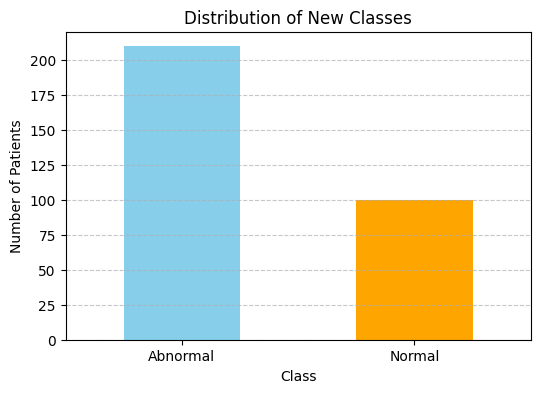

In [22]:
#Load the packages that I will use
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Import data from GitHub
url = "https://raw.githubusercontent.com/lrnv/inf-gram/main/6_final_project/column_3C.txt"
df = pd.read_csv(url, sep='\s+', header=0)
print(df.head())

# a. Display the first lines
print("First 5 rows of the dataset:")
print(df.head())

# b. Display the number of rows and columns
rows, cols = df.shape
print("\nNumber of rows:", rows)
print("Number of columns:", cols)

# c. Check the data type of each column
print("\nData types of each column:")
print(df.dtypes)

# d. Check if there is any missing value
print("\nNumber of missing values in each column:")
print(df.isnull().sum())

# e. Count the number of rows for each class
print("\nNumber of patients in each class:")
print(df['class'].value_counts())

# Create a new column 'new_class' based on the mapping
df['new_class'] = df['class'].apply(lambda x: 'Normal' if x == 'NO' else 'Abnormal')

# Display the new class distribution as a table
new_class_counts = df['new_class'].value_counts()
print("\nNew class distribution:")
print(new_class_counts)

# Plot the distribution as a bar graph
plt.figure(figsize=(6, 4))
new_class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of New Classes')
plt.xlabel('Class')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Task 2

Mean and Standard Deviation for Each Numeric Feature:
      pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
mean         60.496484    17.542903              51.930710     42.953871   
std          17.236109    10.008140              18.553766     13.422748   

      pelvic_radius  degree_spondylolisthesis  
mean     117.920548                 26.296742  
std       13.317629                 37.558883  

Mean and Standard Deviation for Each Numeric Feature by Class:
          pelvic_incidence            pelvic_tilt             \
                      mean        std        mean        std   
new_class                                                      
Abnormal         64.692143  17.661807   19.791048  10.515653   
Normal           51.685600  12.367900   12.821800   6.778658   

          lumbar_lordosis_angle            sacral_slope             \
                           mean        std         mean        std   
new_class                                       

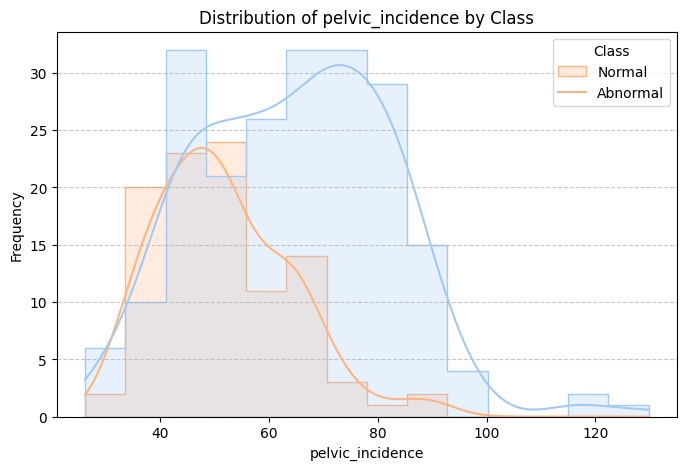

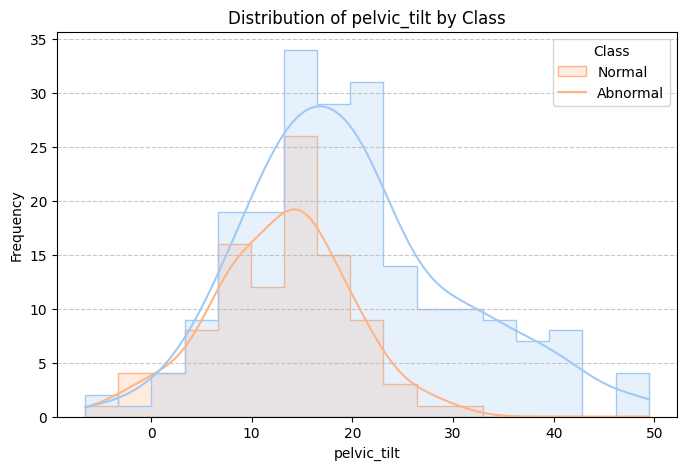

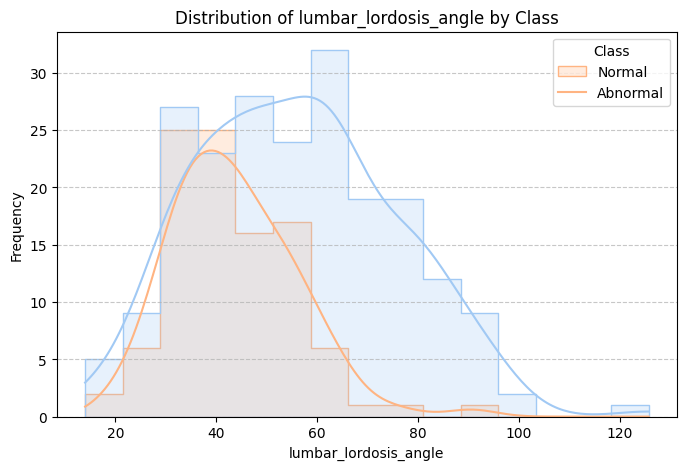

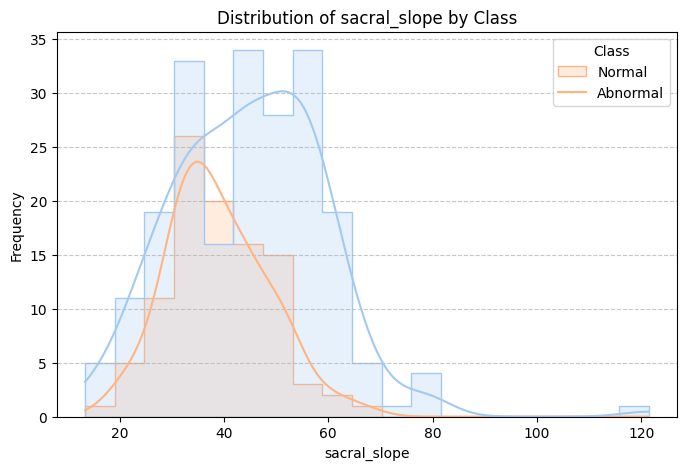

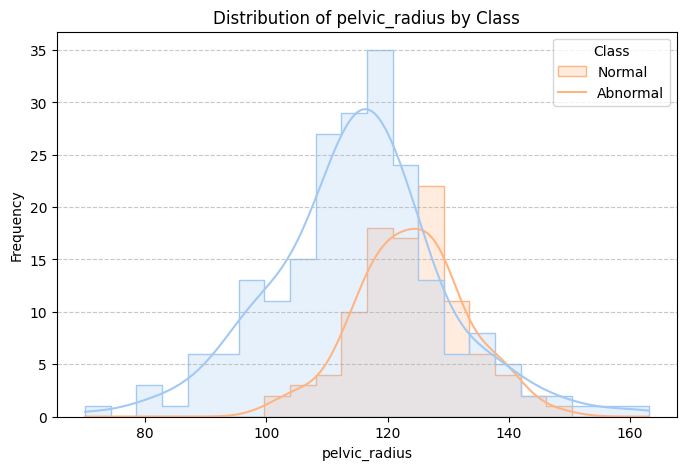

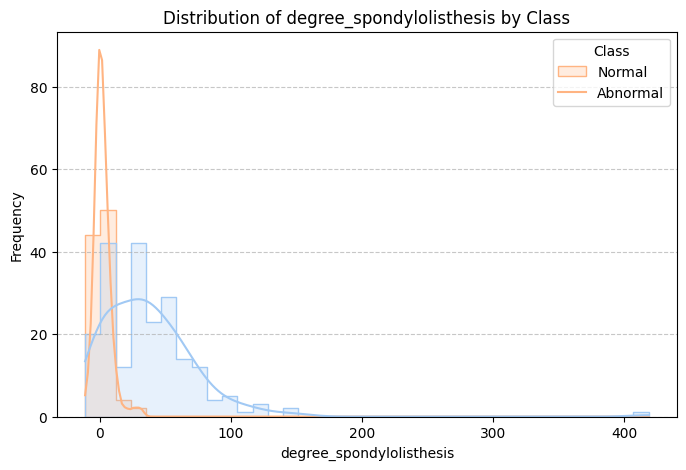

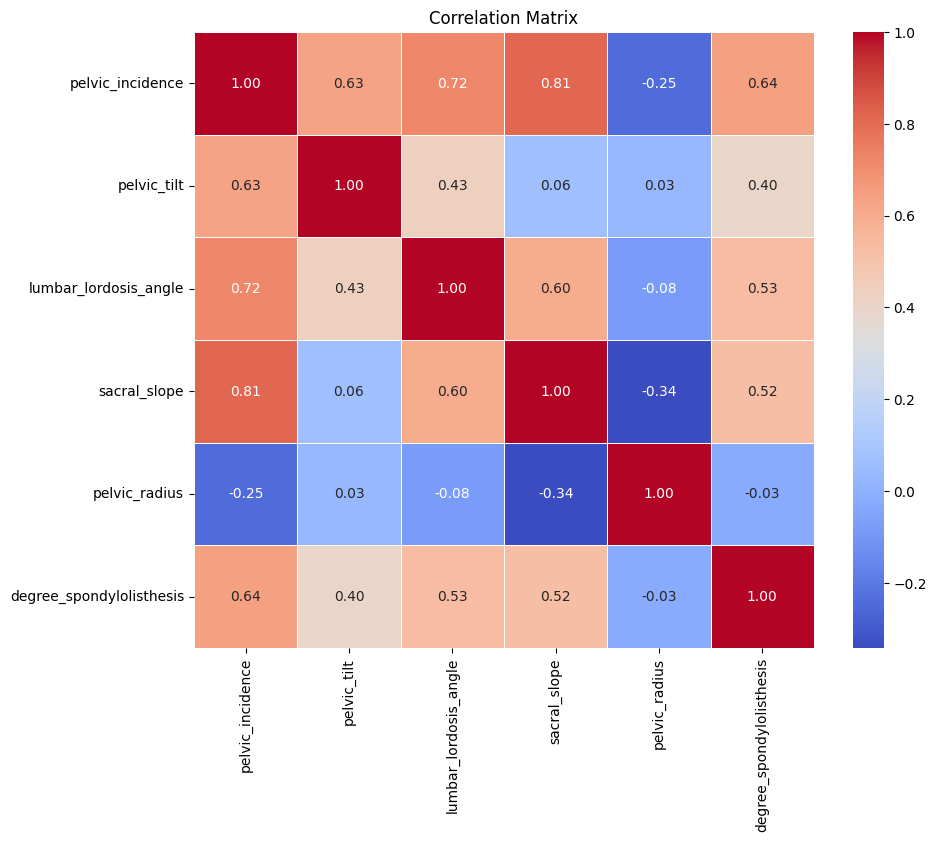

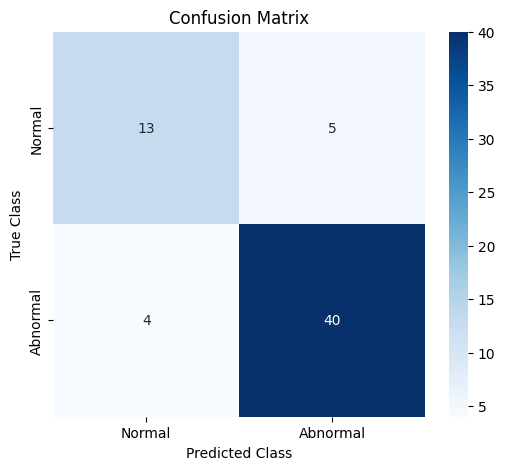


Feature Stats (Mean and Std):
      pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
mean         60.496484    17.542903              51.930710     42.953871   
std          17.236109    10.008140              18.553766     13.422748   

      pelvic_radius  degree_spondylolisthesis  
mean     117.920548                 26.296742  
std       13.317629                 37.558883  

Grouped Stats by Class:
          pelvic_incidence            pelvic_tilt             \
                      mean        std        mean        std   
new_class                                                      
Abnormal         64.692143  17.661807   19.791048  10.515653   
Normal           51.685600  12.367900   12.821800   6.778658   

          lumbar_lordosis_angle            sacral_slope             \
                           mean        std         mean        std   
new_class                                                            
Abnormal               55.92519  19.6689

In [23]:
# 1. Mean and standard deviation for each numeric feature
numeric_features = df.select_dtypes(include=[np.number]).columns
feature_stats = df[numeric_features].describe().loc[['mean', 'std']]
print("Mean and Standard Deviation for Each Numeric Feature:")
print(feature_stats)

# 2. Mean and standard deviation for each numeric feature by class
grouped_stats = df.groupby('new_class')[numeric_features].agg(['mean', 'std'])
print("\nMean and Standard Deviation for Each Numeric Feature by Class:")
print(grouped_stats)

# 3. Distribution of each numeric feature by class (histograms)
for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, hue='new_class', kde=True, palette="pastel", element="step")
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Class', labels=['Normal', 'Abnormal'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# 4. Compute the correlation matrix
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Task 2: Splitting the dataset into training and test samples
X = df[numeric_features]  # Features
y = (df['new_class'] == 'Abnormal').astype(int)  # Target variable as binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Task 3: Logistic Regression

# 1. Build logistic regression model and fit to the training data
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# 2. Predict on the test sample
y_pred = log_reg.predict(X_test)

# 3. Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# 4. Performance indicators
classification_report_str = classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal'])

# Output Results
print("\nFeature Stats (Mean and Std):")
print(feature_stats)

print("\nGrouped Stats by Class:")
print(grouped_stats)

print("\nClassification Report:")
print(classification_report_str)